
## Total Process: 
### Part-0:  Fire the System

    Steps#0 :- Fire the System-- Import Libraries

### Part-1 : Data Pre-Processing

    Steps#1 :- Read Data
    Steps#2 :- Data Pre-Processing(shaping and Transform)

### Part-2 : Create a Model  and Train it

    Steps#3 :- Building-up the Lstm based Neural Network
    Steps#4 :-Start Training

### Part-3 : Make Future Prediction


    Steps#5 :-  Make Predictions for Future Dates
    Steps#6 :- Visualize the Predictions


In [ ]:
# Steps#0 :- Fire the System-- Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import Callback,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,EarlyStopping

*` Steps#1 :- Read Data`*

In [ ]:
# Steps#1 :- Read Data

#Ticker Symbol
company = 'AAPL'
#Start and End Time 
start = dt.datetime(2012,1,1)
end = dt.datetime.now()

actual_data = web.DataReader(company, 'yahoo', start, end)
actual_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.650659
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.718646
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.859850
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.994284
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.973674
...,...,...,...,...,...,...
2021-04-19,135.470001,133.339996,133.509995,134.839996,94264200.0,134.839996
2021-04-20,135.529999,131.809998,135.020004,133.110001,94812300.0,133.110001
2021-04-21,133.750000,131.300003,132.360001,133.500000,68847100.0,133.500000


In [ ]:
#selecting features(columns) to br involved into training data set
dataset_train = actual_data
cols = list(dataset_train)[0:6]
#extracting dates that will be used in visualization
datelist_train = pd.to_datetime(dataset_train.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
#datelist_train = list(dataset_train.index)
datelist_train = [dt.datetime.strptime(date,'%Y-%m-%d').date() for date in datelist_train]
      #datelist_train
print('Training set Shape = {}'.format(dataset_train.shape))
print('All Timestamps = {}'.format(len(datelist_train)))
print('Features Selected = {}'.format(cols))

Training set Shape = (2342, 6)
All Timestamps = 2342
Features Selected = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


 *` Steps#2 :- Data Preprocessing(Scaling and Transform)`*

In [ ]:
# Removing all commas and convert data to matrix shape format
dataset_train = dataset_train[cols].astype(str)
for i in cols:
  for j in range(0,len(dataset_train)):
    dataset_train[i][j]=dataset_train[i][j].replace(',','')

dataset_train=dataset_train.astype(float)
#Using Multiple Prediction
training_set = dataset_train.to_numpy()
print('Shape of Training Set == {}'.format(training_set.shape))
training_set

Shape of Training Set == (2342, 6)


array([[1.47321434e+01, 1.46071434e+01, 1.46214294e+01, 1.46867857e+01,
        3.02220800e+08, 1.26506586e+01],
       [1.48100004e+01, 1.46171427e+01, 1.46428566e+01, 1.47657137e+01,
        2.60022000e+08, 1.27186460e+01],
       [1.49482136e+01, 1.47382135e+01, 1.48196430e+01, 1.49296427e+01,
        2.71269600e+08, 1.28598499e+01],
       ...,
       [1.33750000e+02, 1.31300003e+02, 1.32360001e+02, 1.33500000e+02,
        6.88471000e+07, 1.33500000e+02],
       [1.34149994e+02, 1.31410004e+02, 1.33039993e+02, 1.31940002e+02,
        8.45665000e+07, 1.31940002e+02],
       [1.35119995e+02, 1.32160004e+02, 1.32160004e+02, 1.34320007e+02,
        7.86575000e+07, 1.34320007e+02]])

In [ ]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc =StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict_open = StandardScaler()
sc_predict_open.fit_transform(training_set[:,2:3]) #Open Price

array([[-0.93784014],
       [-0.93709983],
       [-0.93099185],
       ...,
       [ 3.1300394 ],
       [ 3.15353322],
       [ 3.12312949]])

In [ ]:
#create a data structure with 90 time stamp and 1 output
n_future=60 #number of days we want to predict into the future
n_past = 90 #number of past days we want to use to predict

x_train = []
y_train = []

for i in range(n_past, len(training_set_scaled )- n_future +1):
  x_train.append(training_set_scaled[i - n_past:i , 0:dataset_train.shape[1]-1])
  y_train.append(training_set_scaled[i + n_future -1:i + n_future , 0])

x_train,y_train = np.array(x_train),np.array(y_train)
print('Shape of x_train == {}'.format(x_train.shape) )
print('Shape of y_train == {}'.format(y_train.shape) )

Shape of x_train == (2193, 90, 5)
Shape of y_train == (2193, 1)


*` Steps#3 :- Building-up the Lstm based Neural Network `* 


In [ ]:
#importing LSTM related Libraries
from keras.models import Sequential
from keras.layers import  Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

In [ ]:
#initializing the neural network based on LSTM model 
model = Sequential()

#Adding LSTM Layer
model.add(LSTM(units=65, return_sequences=True, input_shape =(n_past,dataset_train.shape[1]-1)))
#Adding 2nd LSTM Layer
model.add(LSTM(units = 35, return_sequences=True))
#Adding 3rd LSTM Layer
model.add(LSTM(units = 35, return_sequences=False))
#Adding Droupout Layer
model.add(Dropout(0.12))
#Adding Dense/Output Layer
model.add(Dense(units=1,activation='linear'))

#Compiling Neural Network
model.compile(optimizer = Adam(learning_rate=0.01),loss='mean_squared_error')

#model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 90, 65)            18460     
_________________________________________________________________
lstm_7 (LSTM)                (None, 90, 35)            14140     
_________________________________________________________________
lstm_8 (LSTM)                (None, 35)                9940      
_________________________________________________________________
dropout_3 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 36        
Total params: 42,576
Trainable params: 42,576
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
es = EarlyStopping(monitor='val_loss',min_delta = 1e-10 , patience = 10, verbose = 1)
rlr =  ReduceLROnPlateau(monitor='val_loss',factor = 0.2 , patience = 10, verbose = 1)
mcp = ModelCheckpoint(filepath='weights.h5',monitor='val_loss',verbose=1, save_best_only=True,save_weights_only=True)
tb = TensorBoard('logs')
history = model.fit(x_train,y_train,shuffle=True,epochs=10,callbacks=[es,rlr,mcp,tb],validation_split=0.2,batch_size=60)

Epoch 1/10
30/30 [==============================] - 12s 236ms/step - loss: 0.1385 - val_loss: 4.9974

Epoch 00001: val_loss improved from inf to 4.99739, saving model to weights.h5
Epoch 2/10
30/30 [==============================] - 5s 160ms/step - loss: 0.0147 - val_loss: 4.2673

Epoch 00002: val_loss improved from 4.99739 to 4.26732, saving model to weights.h5
Epoch 3/10
30/30 [==============================] - 5s 160ms/step - loss: 0.0131 - val_loss: 4.6234

Epoch 00003: val_loss did not improve from 4.26732
Epoch 4/10
30/30 [==============================] - 5s 162ms/step - loss: 0.0105 - val_loss: 4.7550

Epoch 00004: val_loss did not improve from 4.26732
Epoch 5/10
30/30 [==============================] - 5s 163ms/step - loss: 0.0098 - val_loss: 4.6196

Epoch 00005: val_loss did not improve from 4.26732
Epoch 6/10
30/30 [==============================] - 5s 161ms/step - loss: 0.0095 - val_loss: 4.5709

Epoch 00006: val_loss did not improve from 4.26732
Epoch 7/10
30/30 [=========

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [ ]:
# Perform predictions
predictions_future = model.predict(x_train[-n_future:])

predictions_train = model.predict(x_train[n_past:])

In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict_open.inverse_transform(predictions_future)
y_pred_train = sc_predict_open.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.tail(3)

,Open
2021-04-21,38.517632
2021-04-22,38.585056
2021-04-23,38.670670


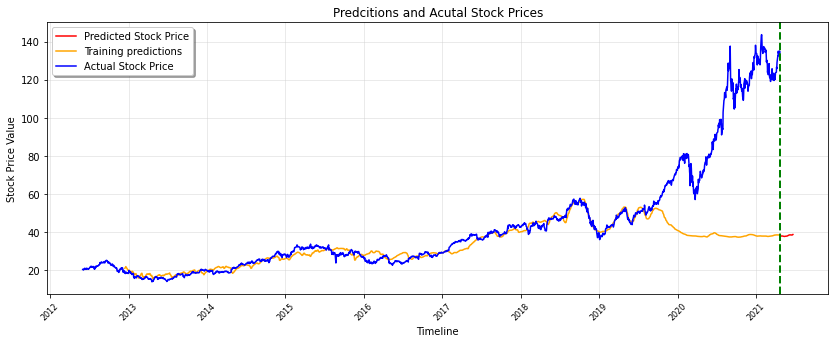

In [ ]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()